In [4]:
!pip install kaggle tensorflow matplotlib scikit-learn opencv-python

import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

from google.colab import files

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import cv2


In [5]:
print("Upload your kaggle.json file")
uploaded = files.upload()

os.makedirs("/root/.kaggle", exist_ok=True)
for fname in uploaded.keys():
    os.rename(fname, "/root/.kaggle/kaggle.json")

!chmod 600 /root/.kaggle/kaggle.json


Upload your kaggle.json file


Saving kaggle.json to kaggle.json


In [6]:
# Download Natural Images dataset
!kaggle datasets download -d prasunroy/natural-images

# Unzip into current directory
with zipfile.ZipFile("natural-images.zip", "r") as zip_ref:
    zip_ref.extractall(".")

# Check what got extracted
print(os.listdir("."))


Dataset URL: https://www.kaggle.com/datasets/prasunroy/natural-images
License(s): CC-BY-NC-SA-4.0
 93% 318M/342M [00:00<00:00, 416MB/s]
100% 342M/342M [00:00<00:00, 414MB/s]
['.config', 'natural_images', 'data', 'natural-images.zip', 'sample_data']


In [7]:
# Dataset path (root folder that contains class subfolders)
dataset_path = "natural_images"
print("Using dataset path:", dataset_path)
print("Classes:", os.listdir(dataset_path))

img_size = 128
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

num_classes = train_gen.num_classes
print("Number of classes:", num_classes)
print("Class indices:", train_gen.class_indices)


Using dataset path: natural_images
Classes: ['dog', 'fruit', 'cat', 'airplane', 'motorbike', 'flower', 'car', 'person']
Found 5522 images belonging to 8 classes.
Found 1377 images belonging to 8 classes.
Number of classes: 8
Class indices: {'airplane': 0, 'car': 1, 'cat': 2, 'dog': 3, 'flower': 4, 'fruit': 5, 'motorbike': 6, 'person': 7}


In [8]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(0.0005),
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,672 (12.61 MB)

 Trainable params: 3,305,672 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
epochs = 20

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.4375 - loss: 1.5098 - val_accuracy: 0.7458 - val_loss: 0.7445
Epoch 2/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.7699 - loss: 0.6385 - val_accuracy: 0.8279 - val_loss: 0.4817
Epoch 3/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.8164 - loss: 0.5010 - val_accuracy: 0.8359 - val_loss: 0.4039
Epoch 4/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.8480 - loss: 0.4051 - val_accuracy: 0.8569 - val_loss: 0.3682
Epoch 5/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.8718 - loss: 0.3525 - val_accuracy: 0.8642 - val_loss: 0.3910
Epoch 6/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.8818 - loss: 0.3192 - val_accuracy: 0.8954 - val_loss: 0.3058
Epoch 7/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.8895 - loss: 0.2916 - val_accuracy: 0.9005 - val_loss: 0.2783
Epoch 8/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.8995 - loss: 0.2756 - val_accu

44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 489ms/step


<Figure size 800x800 with 0 Axes>

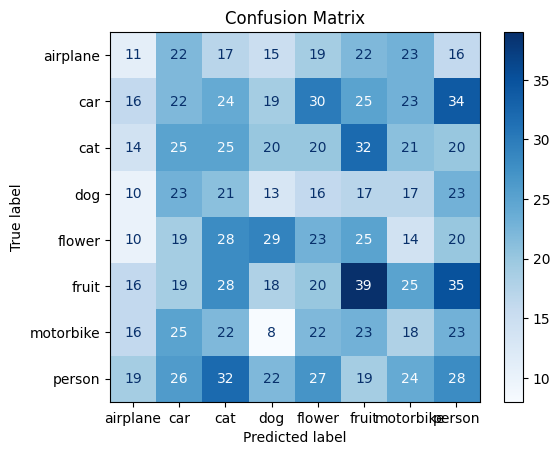

Classification Report:
              precision    recall  f1-score   support

    airplane       0.10      0.08      0.09       145
         car       0.12      0.11      0.12       193
         cat       0.13      0.14      0.13       177
         dog       0.09      0.09      0.09       140
      flower       0.13      0.14      0.13       168
       fruit       0.19      0.20      0.19       200
   motorbike       0.11      0.11      0.11       157
      person       0.14      0.14      0.14       197

    accuracy                           0.13      1377
   macro avg       0.13      0.13      0.13      1377
weighted avg       0.13      0.13      0.13      1377



In [10]:
val_gen.reset()
Y_pred = model.predict(val_gen)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_gen.classes

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=list(train_gen.class_indices.keys()))

plt.figure(figsize=(8,8))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(train_gen.class_indices.keys())))


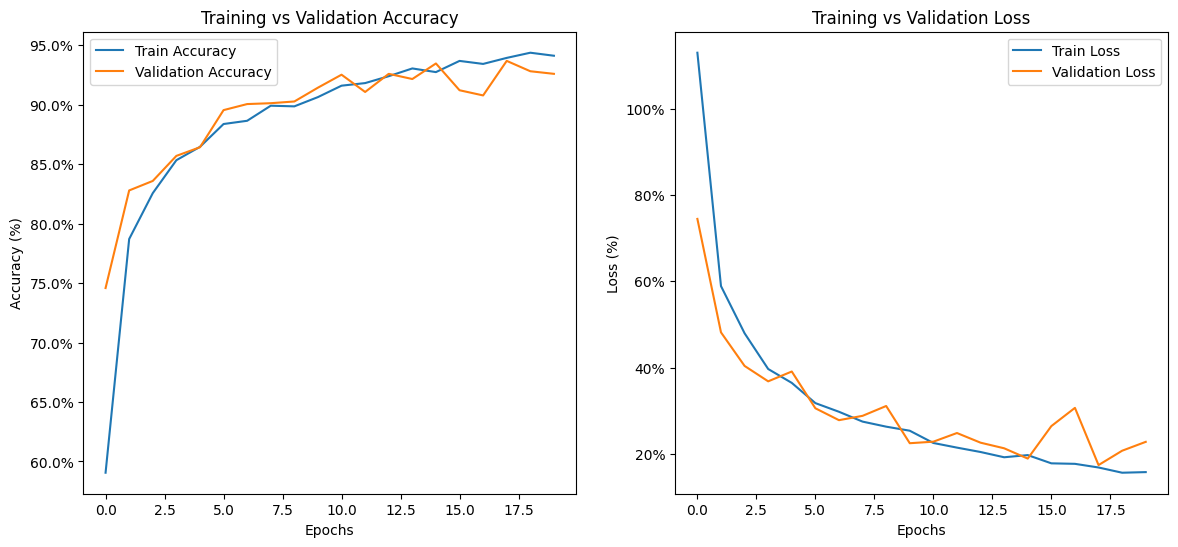

Final Training Accuracy: 94.11%
Final Validation Accuracy: 92.59%
Final Training Loss: 15.80%
Final Validation Loss: 22.81%


In [12]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (%)")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.legend()

plt.show()

final_train_acc = train_acc[-1] * 100
final_val_acc = val_acc[-1] * 100
final_train_loss = train_loss[-1] * 100
final_val_loss = val_loss[-1] * 100

print(f"Final Training Accuracy: {final_train_acc:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc:.2f}%")
print(f"Final Training Loss: {final_train_loss:.2f}%")
print(f"Final Validation Loss: {final_val_loss:.2f}%")


Upload an image for prediction:


Saving premium_photo-1679830513886-e09cd6dc3137.jpeg to premium_photo-1679830513886-e09cd6dc3137.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


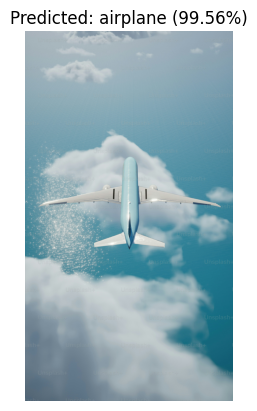

In [11]:
print("Upload an image for prediction:")
uploaded_img = files.upload()

for fn in uploaded_img.keys():
    # Read image
    img = cv2.imread(fn)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Preprocess
    img_resized = cv2.resize(img_rgb, (img_size, img_size))
    img_array = img_resized.astype("float32") / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    preds = model.predict(img_array)
    class_id = np.argmax(preds)
    class_name = list(train_gen.class_indices.keys())[class_id]
    confidence = np.max(preds) * 100

    # Show
    plt.imshow(img_rgb)
    plt.title(f"Predicted: {class_name} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()
